# Pairwise Confusion

The performance we got earlier just touched 90% accuracy on the validation set, so we are a little far off from the state of the art. Let's try out this regularisation idea that forces models to generalise and learn interclass distinctions a little better. For now, our model is good at telling apart the makes of cars, but it isn't doing so well when different models of the same make are quite similar. https://arxiv.org/pdf/1705.08016v3.pdf

In [1]:
from fastai.vision import *
from fastai.utils.ipython import * 

In [2]:
from fastai.callbacks.tracker import *

In [3]:
import pickle
with open('labels.pkl','rb') as f:
    labels = pickle.load(f)

In [4]:
path = Path('./')

In [5]:
seed = 42
src = (ImageList
       .from_folder(path,include='cars_train',extensions='.jpg')
       .split_by_rand_pct(0.15,seed=42)
       .label_from_func(lambda x: labels[x.name])
      )

In [6]:
data = (src
        .transform(get_transforms(),size=(299,299))
        .databunch(bs=40)
        .normalize(imagenet_stats)
       )

In [7]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)

<strong>Carry on with the below cells to start training, skip to the next section if you just want to carry out inference on a test set. </strong>

In [9]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [10]:
class PWCLoss():
    def __init__(self,l=1):
        self.l = l
        self.train = True
    def __call__(self,inp,targ,reduction=None):

        loss = FlattenedLoss(CrossEntropyFlat)(inp,targ)
        if self.train:
            if(len(inp)%2!=0):
                return loss
            inp1, inp2 = inp.chunk(2,0)
            targ1, targ2 = targ.chunk(2)
            mask = (targ1 != targ2).float()
            bs = len(inp1)
            pwc = torch.zeros(bs).cuda()
            for i in range(bs):
                pwc[i] = torch.dist(inp1[i],inp2[i]).cuda()
            pwc = self.l * pwc * mask / bs
        #     import pdb; pdb.set_trace()
            return loss + pwc.mean()
        else:
            return loss

In [ ]:
learn.loss_func = PWCLoss()

We load a model that we trained earlier.

In [12]:
# learn.load('20_epoch_resnet50_299_unfrozen_2');

In [ ]:
learn.fit_one_cycle(15,slice(1e-5,5e-4))

In [16]:
learn.save('1_resnet50_299_pwc') #0.8965

In [13]:
learn.load('1_resnet50_299_pwc');

In [18]:
learn.unfreeze();
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


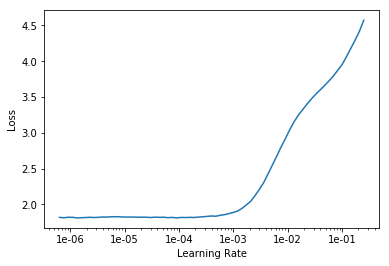

In [19]:
learn.recorder.plot() 

In [14]:
learn.fit_one_cycle(15,slice(1e-6,1e-4),callbacks=[SaveModelCallback(learn,every='improvement',name='2_resnet50_299_pwc')])

epoch,train_loss,valid_loss,accuracy,time
0,0.448136,0.740648,0.901720,02:24
1,0.410216,0.698811,0.900901,02:15
2,0.349873,0.628840,0.902539,02:16
3,0.277905,0.555477,0.902539,02:16
4,0.227965,0.499696,0.903358,02:16
5,0.187007,0.457273,0.903358,02:14
6,0.151006,0.431260,0.903358,02:15
7,0.131999,0.414178,0.906634,02:15
8,0.124413,0.402015,0.904996,02:16
9,0.107301,0.395384,0.903358,02:18


Better model found at epoch 0 with valid_loss value: 0.7406482100486755.
Better model found at epoch 1 with valid_loss value: 0.6988109350204468.
Better model found at epoch 2 with valid_loss value: 0.6288403868675232.
Better model found at epoch 3 with valid_loss value: 0.5554767847061157.
Better model found at epoch 4 with valid_loss value: 0.4996959865093231.
Better model found at epoch 5 with valid_loss value: 0.45727330446243286.
Better model found at epoch 6 with valid_loss value: 0.4312599301338196.
Better model found at epoch 7 with valid_loss value: 0.4141782820224762.
Better model found at epoch 8 with valid_loss value: 0.40201491117477417.
Better model found at epoch 9 with valid_loss value: 0.3953840136528015.
Better model found at epoch 10 with valid_loss value: 0.3896302580833435.
Better model found at epoch 11 with valid_loss value: 0.38676178455352783.
Better model found at epoch 12 with valid_loss value: 0.38653266429901123.
Better model found at epoch 13 with valid_lo

In [15]:
learn.fit_one_cycle(20,slice(5e-6,1e-4),callbacks=[SaveModelCallback(learn,every='improvement',name='3_resnet50_299_pwc')])

epoch,train_loss,valid_loss,accuracy,time
0,0.098944,0.382720,0.904177,02:15
1,0.101947,0.382916,0.908272,02:16
2,0.095513,0.378390,0.906634,02:16
3,0.094250,0.375337,0.907453,02:16
4,0.087968,0.367991,0.905815,02:16
5,0.080498,0.363170,0.908272,02:15
6,0.077073,0.356954,0.904996,02:16
7,0.071062,0.356605,0.903358,02:15
8,0.069053,0.351846,0.907453,02:16
9,0.067435,0.351467,0.905815,02:15


Better model found at epoch 0 with valid_loss value: 0.3827202618122101.
Better model found at epoch 2 with valid_loss value: 0.3783903121948242.
Better model found at epoch 3 with valid_loss value: 0.375336617231369.
Better model found at epoch 4 with valid_loss value: 0.3679911494255066.
Better model found at epoch 5 with valid_loss value: 0.363170325756073.
Better model found at epoch 6 with valid_loss value: 0.35695385932922363.
Better model found at epoch 8 with valid_loss value: 0.3518455922603607.
Better model found at epoch 9 with valid_loss value: 0.35146674513816833.
Better model found at epoch 11 with valid_loss value: 0.3498173654079437.
Better model found at epoch 12 with valid_loss value: 0.3476269543170929.
Better model found at epoch 18 with valid_loss value: 0.3456805646419525.


# Inference on Test Set

First load a checkpoint.

In [ ]:
learn.load('3_resnet50_299_pwc');

In [ ]:
#set the path of the folder containing test images
path = Path('/test')
test_imgs = path.ls()
test_imgs.sort(key=lambda x: x.stem)

In [ ]:
#Add test data to the databunch and assign it to the learner.
data.add_test(test_imgs) 
learn.data = data

In [ ]:
res = learn.TTA(ds_type=DatasetType.Test,with_loss=True)
preds = res[0].argmax(-1)

# END